In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
import seaborn as sns
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
#Data transforms with more augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
#Training images
# Load datasets
trainset = torchvision.datasets.ImageFolder(root=r'C:\Users\omerf\OneDrive\Masaüstü\Learning From Data Project\classes_train', transform=transform)
testset = torchvision.datasets.ImageFolder(root=r'C:\Users\omerf\OneDrive\Masaüstü\Learning From Data Project\classes_test', transform=transform)

In [4]:
#Creating sampler for class balance
class_counts = [len([label for _, label in trainset if label == i]) for i in range(10)]
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = [0] * len(trainset)

for idx, (data, label) in enumerate(trainset):
    class_weight = class_weights[label]
    sample_weights[idx] = class_weight

sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(sample_weights))

loader_train = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=sampler, num_workers=8)
loader_test = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=8)

In [5]:
# Define the embedding model with dropout
class EmbeddingModel(nn.Module):
    def __init__(self, base_model, embedding_size):
        super(EmbeddingModel, self).__init__()
        self.base_model = nn.Sequential(*list(base_model.children())[:-1])
        self.fc = nn.Linear(base_model.fc.in_features, embedding_size)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.base_model(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.relu(x)
        return x

In [6]:
# Load pretrained ResNet18 and create embedding model
resnet = torchvision.models.resnet18(pretrained=True)
embedding_resnet = EmbeddingModel(resnet, embedding_size=128).to(device)

C:\Users\omerf\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\omerf\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
#Define contrastive loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    
    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [8]:
criterion_contrastive = ContrastiveLoss()
optimizer_contrastive = optim.Adam(embedding_resnet.parameters(), lr=0.00001)

In [9]:
# Function to create pairs
def create_pairs(images, labels, num_pairs=16):
    pairs = []
    for i in range(num_pairs):
        idx1, idx2 = torch.randint(0, len(images), (2,))
        img1, img2 = images[idx1], images[idx2]
        label = torch.tensor(int(labels[idx1] == labels[idx2]), dtype=torch.float32)
        pairs.append((img1, img2, label))
    return pairs

In [10]:
# Training loop for the contrastive loss
losses = []
num_epochs_contrastive = 10
for epoch in range(num_epochs_contrastive):
    embedding_resnet.train()
    running_loss = 0.0
    for images, labels in loader_train:
        images, labels = images.to(device), labels.to(device)
        pairs = create_pairs(images, labels, num_pairs=16)
        for img1, img2, label in pairs:
            optimizer_contrastive.zero_grad()
            img1, img2, label = img1.unsqueeze(0).to(device), img2.unsqueeze(0).to(device), label.to(device)
            
            output1 = embedding_resnet(img1)
            output2 = embedding_resnet(img2)
            
            loss = criterion_contrastive(output1, output2, label)
            
            loss.backward()
            optimizer_contrastive.step()
            
            running_loss += loss.item()
    
    avg_loss = running_loss / len(loader_train)
    print(f"Epoch: {epoch}, Contrastive Loss: {avg_loss:.4f}")
    losses.append(avg_loss)

Epoch: 0, Contrastive Loss: 362.3796
Epoch: 1, Contrastive Loss: 232.3487
Epoch: 2, Contrastive Loss: 169.9138
Epoch: 3, Contrastive Loss: 102.2294
Epoch: 4, Contrastive Loss: 69.6762
Epoch: 5, Contrastive Loss: 43.5829
Epoch: 6, Contrastive Loss: 27.0899
Epoch: 7, Contrastive Loss: 16.1343
Epoch: 8, Contrastive Loss: 8.8825
Epoch: 9, Contrastive Loss: 6.1152
Epoch: 10, Contrastive Loss: 4.5829
Epoch: 11, Contrastive Loss: 3.8809
Epoch: 12, Contrastive Loss: 3.5378
Epoch: 13, Contrastive Loss: 2.9106
Epoch: 14, Contrastive Loss: 2.8193
Epoch: 15, Contrastive Loss: 2.7214
Epoch: 16, Contrastive Loss: 2.3995
Epoch: 17, Contrastive Loss: 2.2058
Epoch: 18, Contrastive Loss: 1.9390
Epoch: 19, Contrastive Loss: 2.0754
Epoch: 20, Contrastive Loss: 1.8709
Epoch: 21, Contrastive Loss: 1.9318
Epoch: 22, Contrastive Loss: 1.8058
Epoch: 23, Contrastive Loss: 2.1017
Epoch: 24, Contrastive Loss: 1.6977
Epoch: 25, Contrastive Loss: 1.8094
Epoch: 26, Contrastive Loss: 1.2530
Epoch: 27, Contrastive Los

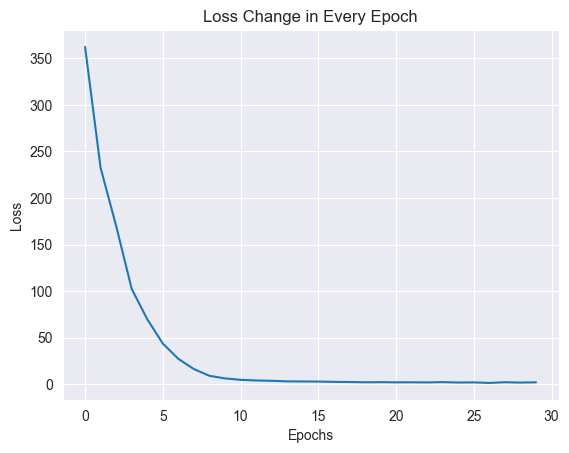

In [12]:
# Plotting the loss
sns.lineplot(x=range(len(losses)), y=losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss Change in Every Epoch")
plt.show()

In [13]:
# Adding linear classifier on top of the Embedding Model with BatchNorm
classifier = nn.Sequential(
    nn.Linear(in_features=128, out_features=512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=10)
).to(device)

class FullModel(nn.Module):
    def __init__(self, embedding_model, classifier):
        super(FullModel, self).__init__()
        self.embedding_model = embedding_model
        self.classifier = classifier
    
    def forward(self, x):
        x = self.embedding_model(x)
        x = self.classifier(x)
        return x

In [14]:
#Create full model
full_model = FullModel(embedding_resnet, classifier).to(device)

In [15]:
#Fine-tuning additional layers
for param in full_model.embedding_model.base_model[-3:].parameters():
    param.requires_grad = True
#Loss and optimizer for the classifier
criterion_classifier = nn.CrossEntropyLoss()
optimizer_classifier = optim.SGD(full_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer_classifier, step_size=7, gamma=0.1)

In [16]:
#Training loop for the classifier
num_epochs_classifier = 30
loss1 = []
accuracy = []

for epoch in range(num_epochs_classifier):
    full_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader_train:
        images, labels = images.to(device), labels.to(device)
        optimizer_classifier.zero_grad()
        
        outputs = full_model(images)
        loss = criterion_classifier(outputs, labels)
        
        loss.backward()
        optimizer_classifier.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_loss = running_loss / len(loader_train)
    acc = 100 * correct / total
    print(f"Epoch: {epoch}, Loss: {avg_loss:.4f}, Accuracy: {acc:.2f}%")
    loss1.append(avg_loss)
    accuracy.append(acc)
    
    scheduler.step()

Epoch: 0, Loss: 2.3596, Accuracy: 10.20%
Epoch: 1, Loss: 2.3515, Accuracy: 13.20%
Epoch: 2, Loss: 2.0276, Accuracy: 20.50%
Epoch: 3, Loss: 1.7710, Accuracy: 24.00%
Epoch: 4, Loss: 1.6510, Accuracy: 31.80%
Epoch: 5, Loss: 1.5118, Accuracy: 38.30%
Epoch: 6, Loss: 1.3266, Accuracy: 50.80%
Epoch: 7, Loss: 1.1551, Accuracy: 56.00%
Epoch: 8, Loss: 1.0647, Accuracy: 59.30%
Epoch: 9, Loss: 1.0725, Accuracy: 59.30%
Epoch: 10, Loss: 1.0706, Accuracy: 59.10%
Epoch: 11, Loss: 1.0452, Accuracy: 60.50%
Epoch: 12, Loss: 0.9445, Accuracy: 64.30%
Epoch: 13, Loss: 0.9579, Accuracy: 62.90%
Epoch: 14, Loss: 0.9378, Accuracy: 65.90%
Epoch: 15, Loss: 0.9481, Accuracy: 65.30%
Epoch: 16, Loss: 0.9386, Accuracy: 65.60%
Epoch: 17, Loss: 0.9476, Accuracy: 63.70%
Epoch: 18, Loss: 0.9354, Accuracy: 65.60%
Epoch: 19, Loss: 0.9625, Accuracy: 64.10%
Epoch: 20, Loss: 0.8907, Accuracy: 65.60%
Epoch: 21, Loss: 0.9631, Accuracy: 65.90%
Epoch: 22, Loss: 0.9565, Accuracy: 62.40%
Epoch: 23, Loss: 0.8927, Accuracy: 66.50%
Ep

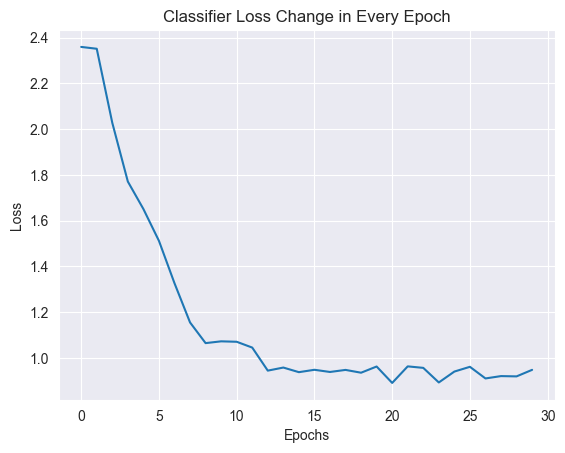

In [17]:
#Plotting the classifier loss
sns.lineplot(x=range(len(loss1)), y=loss1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Classifier Loss Change in Every Epoch")
plt.show()

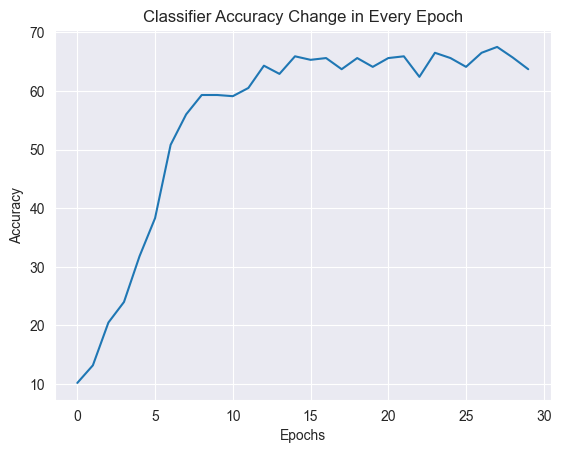

In [18]:
#Plotting the classifier accuracy
sns.lineplot(x=range(len(accuracy)), y=accuracy)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Classifier Accuracy Change in Every Epoch")
plt.show()

In [25]:
#Test Phase
test_losses = []
test_accuracy = []
epoch_test = 10
for epoch in range(epoch_test):
    full_model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader_test:
            images, labels = images.to(device), labels.to(device)
            outputs = full_model(images)
            loss = criterion_classifier(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_test_loss = test_loss / len(loader_test)
    test_losses.append(avg_test_loss)
    test_acc = 100 * correct / total
    test_accuracy.append(test_acc)
    
    print(f"Epoch: {epoch},Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0,Test Loss: 0.9201, Test Accuracy: 65.90%
Epoch: 1,Test Loss: 0.9364, Test Accuracy: 65.60%
Epoch: 2,Test Loss: 0.9416, Test Accuracy: 64.50%
Epoch: 3,Test Loss: 0.9473, Test Accuracy: 64.00%
Epoch: 4,Test Loss: 0.9209, Test Accuracy: 66.80%
Epoch: 5,Test Loss: 0.9305, Test Accuracy: 65.10%
Epoch: 6,Test Loss: 0.9137, Test Accuracy: 64.80%
Epoch: 7,Test Loss: 0.9406, Test Accuracy: 64.30%
Epoch: 8,Test Loss: 0.9225, Test Accuracy: 65.20%
Epoch: 9,Test Loss: 0.9398, Test Accuracy: 65.30%


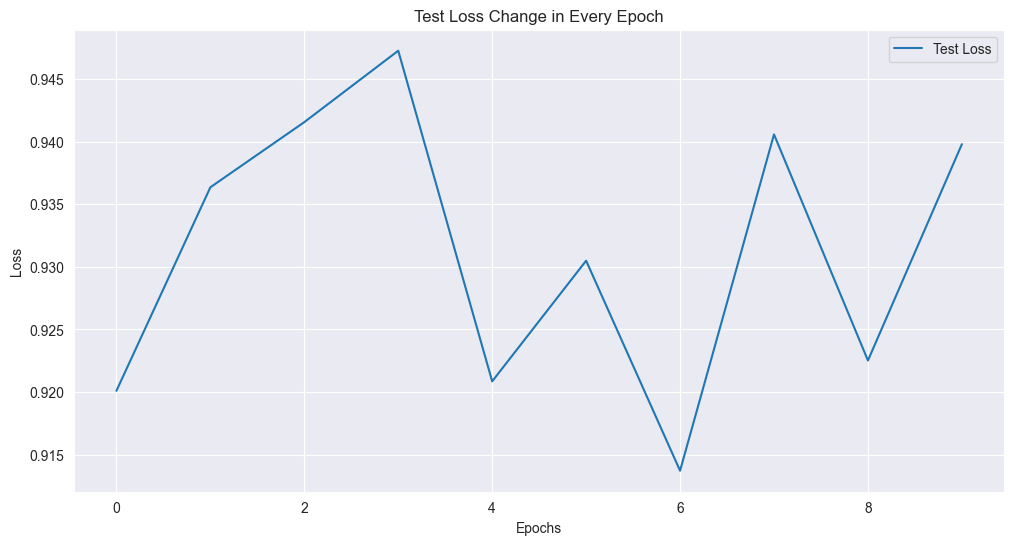

In [26]:
#Plotting the train and test loss
plt.figure(figsize=(12, 6))
sns.lineplot(x=range(len(test_losses)), y=test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Test Loss Change in Every Epoch")
plt.legend()
plt.show()

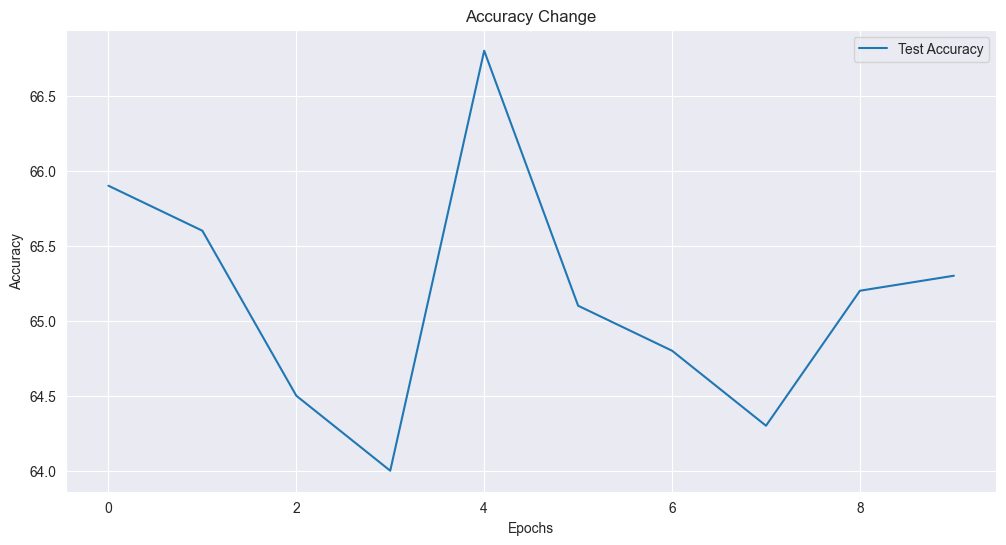

In [27]:
#Plotting the train and test accuracy
plt.figure(figsize=(12, 6))
sns.lineplot(x=range(len(test_accuracy)), y=test_accuracy, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy Change")
plt.legend()
plt.show()